# Waldemar Chang - Assignment 7: Preprocessing Text and Analyzing Reranking
## EN.705.603.82.FA24 Creating AI-Enabled Systems
### Task 1: Preprocess the text data
#### In a notebook called `notebooks/reranker_analysis.ipynb`, demonstrate the output of the following functions using a paragraph in the corpus.

In [1]:
from pipeline import Pipeline
from embedding import Embedding
from preprocessing import DocumentProcessing
from question_answering import QA_Generator
from indexing import FaissIndex
from reranker import Reranker
from search import FaissSearch
import os
import tempfile

# Define the corpus directory
corpus_directory = r'C:\Users\walde\systems\textwave\storage\corpus'

# Initialize Pipeline
pipeline = Pipeline()

# Select a sample file from the corpus
sample_file = os.path.join(corpus_directory, os.listdir(corpus_directory)[0])

# Read the content
with open(sample_file, 'r', encoding='utf-8') as f:
    sample_text = f.read()

print("Sample Text:\n")
print(sample_text)

C:\Users\walde\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Sample Text:

John_Adams



John Adams, Jr. (October 30,1735   July 4, 1826)  was the second President of the United States (1797 1801). He also served as America's first Vice President (1789 1797). He was defeated for re-election in the "Revolution of 1800" by Thomas Jefferson. Adams was also the first President to reside in the newly built White House in Washington, D.C., which was completed in 1800.

Adams, a sponsor of the American Revolution in Massachusetts, was a driving force for independence in 1776; Jefferson called him the "Colossus of Independence". He represented the Continental Congress in Europe. He was a major negotiator of the eventual peace treaty with Great Britain, and chiefly responsible for obtaining the loans from the Amsterdam money market necessary for the conduct of the Revolution. His prestige secured his two elections as Washington's Vice President and his election to succeed him.   As President, he was frustrated by battles inside his own Federalist party a

In [2]:
sample_paragraph = """John Adams, Jr. (October 30,1735   July 4, 1826)  was the second President of the United States (1797 1801). He also served as America's first Vice President (1789 1797). He was defeated for re-election in the "Revolution of 1800" by Thomas Jefferson. Adams was also the first President to reside in the newly built White House in Washington, D.C., which was completed in 1800.

Adams, a sponsor of the American Revolution in Massachusetts, was a driving force for independence in 1776; Jefferson called him the "Colossus of Independence". He represented the Continental Congress in Europe. He was a major negotiator of the eventual peace treaty with Great Britain, and chiefly responsible for obtaining the loans from the Amsterdam money market necessary for the conduct of the Revolution. His prestige secured his two elections as Washington's Vice President and his election to succeed him.   As President, he was frustrated by battles inside his own Federalist party against a faction led by Alexander Hamilton, but he broke with them to avert a major conflict with France in 1798, during the Quasi-War crisis. He became the founder of an important family of politicians, diplomats and historians, and in recent years his reputation has improved."""

# Create a temporary directory and file to simulate a corpus with one paragraph
with tempfile.TemporaryDirectory() as temp_dir:
    # Path for the temporary file
    temp_file_path = os.path.join(temp_dir, "sample_paragraph.txt")
    
    # Write the sample paragraph to the temporary file
    with open(temp_file_path, 'w', encoding='utf-8') as temp_file:
        temp_file.write(sample_paragraph)
    
    # Now, use the temp_dir as the corpus_directory
    # Clear any existing chunks
    pipeline.chunks = []
    
    # Sentence chunking with overlap_size=2
    pipeline.preprocess_corpus(corpus_directory=temp_dir, chunking_strategy='sentence', overlap_size=2)
    
    print("\nSentence Chunking with Overlap Size 2:\n")
    for i, chunk in enumerate(pipeline.chunks, 1):
        print(f"Chunk {i}:\n{chunk}\n")
    
    # Clear chunks before next run
    pipeline.chunks = []
    
    # Sentence chunking with overlap_size=4
    pipeline.preprocess_corpus(corpus_directory=temp_dir, chunking_strategy='sentence', overlap_size=4)
    
    print("\nSentence Chunking with Overlap Size 4:\n")
    for i, chunk in enumerate(pipeline.chunks, 1):
        print(f"Chunk {i}:\n{chunk}\n")
    
    # Clear chunks before next run
    pipeline.chunks = []
    
    # Fixed-length chunking with fixed_length=50, overlap_size=3
    pipeline.preprocess_corpus(corpus_directory=temp_dir, chunking_strategy='fixed-length', fixed_length=50, overlap_size=3)
    
    print("\nFixed-Length Chunking (50 words) with Overlap Size 3:\n")
    for i, chunk in enumerate(pipeline.chunks, 1):
        print(f"Chunk {i}:\n{chunk}\n")
    
    # Clear chunks before next run
    pipeline.chunks = []
    
    # Fixed-length chunking with fixed_length=100, overlap_size=2
    pipeline.preprocess_corpus(corpus_directory=temp_dir, chunking_strategy='fixed-length', fixed_length=100, overlap_size=2)
    
    print("\nFixed-Length Chunking (100 words) with Overlap Size 2:\n")
    for i, chunk in enumerate(pipeline.chunks, 1):
        print(f"Chunk {i}:\n{chunk}\n")
    
    # Clear chunks before next run
    pipeline.chunks = []
    
    # Fixed-length chunking with fixed_length=150, overlap_size=1
    pipeline.preprocess_corpus(corpus_directory=temp_dir, chunking_strategy='fixed-length', fixed_length=150, overlap_size=1)
    
    print("\nFixed-Length Chunking (150 words) with Overlap Size 1:\n")
    for i, chunk in enumerate(pipeline.chunks, 1):
        print(f"Chunk {i}:\n{chunk}\n")

Generated 5 chunks:
Chunk 1: 'John Adams, Jr. (October 30,1735 July 4, 1826) was the second President of the United States (1797 1801). He also served as America's first Vice President (1789 1797).'
Chunk 2: 'He was defeated for re-election in the "Revolution of 1800" by Thomas Jefferson. Adams was also the first President to reside in the newly built White House in Washington, D.C., which was completed in 1800.'
Chunk 3: 'Adams, a sponsor of the American Revolution in Massachusetts, was a driving force for independence in 1776; Jefferson called him the "Colossus of Independence". He represented the Continental Congress in Europe.'
Chunk 4: 'He was a major negotiator of the eventual peace treaty with Great Britain, and chiefly responsible for obtaining the loans from the Amsterdam money market necessary for the conduct of the Revolution. His prestige secured his two elections as Washington's Vice President and his election to succeed him.'
Chunk 5: 'As President, he was frustrated by b

### Task 2: Analyze the Re-ranker
#### In a notebook called `notebooks/reranker_analysis.ipynb`, visually analyze four re-ranking strategies and assess how your findings will impact your system design.

In [3]:
import sys
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
from reranker import Reranker

# Load the cross-encoder model and tokenizer
cross_encoder_model_name = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
cross_encoder_model = AutoModelForSequenceClassification.from_pretrained(cross_encoder_model_name)
tokenizer = AutoTokenizer.from_pretrained(cross_encoder_model_name)

# Load the embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Instantiate the QA Generator
qa_generator = QA_Generator()

In [4]:
# For simplicity, we can split the text into paragraphs
corpus = sample_text.split('\n\n')

# Remove empty strings
corpus = [para.strip() for para in corpus if para.strip()]

In [5]:
def display_results(ranked_documents, scores, strategy_name, top_k=3):
    print(f"\n{strategy_name} Results (Top {top_k}):")
    for i, (doc, score) in enumerate(zip(ranked_documents[:top_k], scores[:top_k]), 1):
        print(f"Rank {i}: Score {score:.4f}\nDocument: {doc[:200]}...\n")  # Display first 200 characters

    plt.figure(figsize=(8, 6))
    doc_labels = [f"Doc {i}" for i in range(1, top_k + 1)]
    plt.bar(doc_labels, scores[:top_k], color='skyblue')
    plt.title(f"{strategy_name} - Top {top_k} Document Scores")
    plt.xlabel("Documents")
    plt.ylabel("Scores")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Cross-Encoder-Only Strategy


Cross-Encoder-Only Results (Top 3):
Rank 1: Score 9.1589
Document: In 1764, Adams married Abigail Smith (1744–1818), the daughter of a Congregational minister,Rev. William Smith, at Weymouth, Massachusetts. Their children were Abigail (1765-1813); future president Jo...

Rank 2: Score 3.8088
Document: His daughter Abigail ("Nabby") was married to Congressman William Stephens Smith and died of cancer in 1816. His son Charles died as an alcoholic in 1800. His son Thomas and his family lived with Adam...

Rank 3: Score 0.7726
Document: John Adams, Jr. (October 30,1735   July 4, 1826)  was the second President of the United States (1797 1801). He also served as America's first Vice President (1789 1797). He was defeated for re-electi...



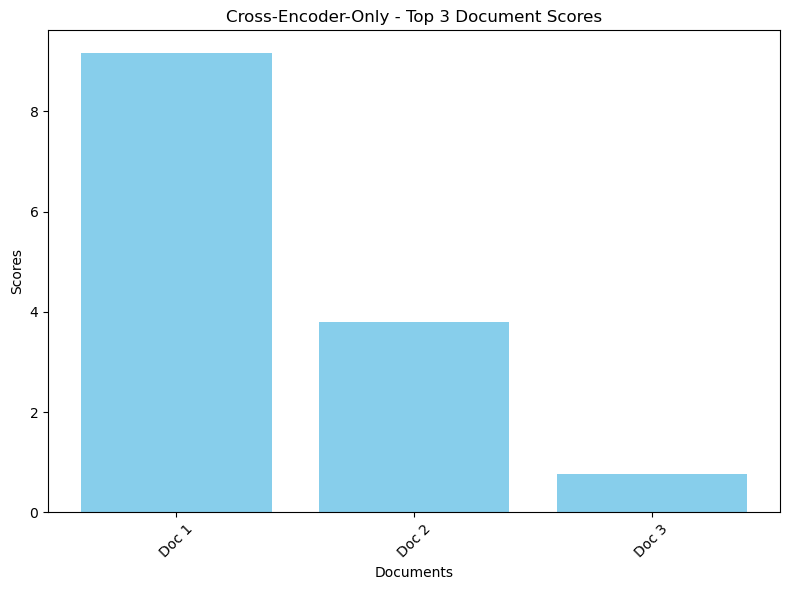

[ChatCompletionChoice(index=0, message=AssistantMessage(content='John Adams was married to Abigail Smith.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]
Cross-Encoder-Only Answer:
John Adams was married to Abigail Smith.



In [6]:
query = "Who was John Adams married to?"
reranker = Reranker(type="cross_encoder")
ranked_docs, ranked_indices, scores = reranker.rerank(query, corpus)

display_results(ranked_docs, scores, "Cross-Encoder-Only", top_k=3)

top_doc = ranked_docs[:3]
answer = qa_generator.generate_answer(query, top_doc)
print(f"Cross-Encoder-Only Answer:\n{answer}\n")

### Analysis

The Cross-Encoder-Only strategy employs a cross-encoder model that jointly encodes the query and each document to compute a relevance score. This method allows for a deep semantic understanding between the query and the documents, enabling the model to capture nuanced relationships that keyword-based methods might miss. In the results, the top-ranked document scored a high 9.1589 and directly addressed the query by detailing John Adams's marriage to Abigail Smith. The second and third documents, with scores of 3.8088 and 0.7726 respectively, were less relevant but still related to his family.

The QA_Generator produced the answer "John Adams was married to Abigail Smith," demonstrating that the model effectively utilized the most relevant context. The high score of the top document indicates that the cross-encoder successfully identified the most pertinent information. This level of precision is ideal for systems where accuracy is critical.

However, the computational intensity of encoding each query-document pair poses significant challenges for system design. The Cross-Encoder-Only strategy requires substantial processing power, which can lead to increased latency, especially when dealing with large corpora or high volumes of queries. This necessitates the allocation of robust computational resources, such as GPUs or distributed computing clusters, to maintain acceptable response times.

We can infer the computational intensity of this strategy based on the nature of cross-encoder models. Cross-encoders perform pairwise encoding of the query and each document, passing them through a transformer-based neural network to compute similarity scores. This process is computationally expensive because it scales linearly with the number of documents in the corpus. Each query-document pair requires substantial processing, often involving large numbers of parameters and multiple layers in the neural network. This understanding comes from the well-known properties of transformer models, which are resource-intensive due to their self-attention mechanisms and deep architectures.

The computational demands of the Cross-Encoder-Only strategy pose significant challenges for system design. The necessity to process each query-document pair individually leads to increased latency, especially when dealing with large corpora or high query volumes. This necessitates the allocation of robust computational resources, such as GPUs or distributed computing clusters, to maintain acceptable response times.

Incorporating this strategy into a system design means prioritizing accuracy over scalability. For applications where precise answers are essential, such as legal research or medical information retrieval, the investment in computational resources may be justified. System design decisions might consider implementing efficient parallel processing and optimizing code to handle the computational load. Additionally, caching mechanisms for frequent queries can mitigate some performance issues by reusing computed embeddings. Understanding the trade-offs between computational intensity and accuracy is crucial, and this knowledge is derived from theoretical insights into the algorithmic complexity of cross-encoder models.

### TF-IDF-Only Strategy


TF-IDF-Only Results (Top 3):
Rank 1: Score 0.8150
Document: Presidential Dollar of John Adams...

Rank 2: Score 0.8290
Document: In 1764, Adams married Abigail Smith (1744–1818), the daughter of a Congregational minister,Rev. William Smith, at Weymouth, Massachusetts. Their children were Abigail (1765-1813); future president Jo...

Rank 3: Score 0.8466
Document: His daughter Abigail ("Nabby") was married to Congressman William Stephens Smith and died of cancer in 1816. His son Charles died as an alcoholic in 1800. His son Thomas and his family lived with Adam...



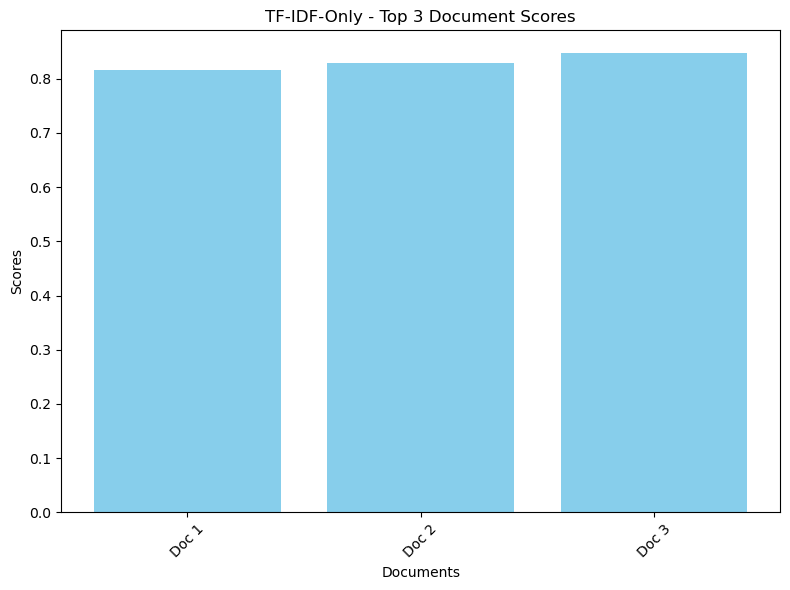

[ChatCompletionChoice(index=0, message=AssistantMessage(content='John Adams was married to Abigail Smith.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]
TF-IDF-Only Answer:
John Adams was married to Abigail Smith.



In [7]:
reranker = Reranker(type="tfidf")
ranked_docs, ranked_indices, scores = reranker.rerank(query, corpus)

display_results(ranked_docs, scores, "TF-IDF-Only", top_k=3)

top_doc = ranked_docs[:3]
answer = qa_generator.generate_answer(query, top_doc)
print(f"TF-IDF-Only Answer:\n{answer}\n")

### Analysis

The TF-IDF-Only strategy relies on term frequency-inverse document frequency to rank documents based on keyword occurrences. This method is computationally efficient and easy to implement but lacks semantic understanding. In the results, the top-ranked document had a score of 0.8150 and was about the "Presidential Dollar of John Adams," which is not directly relevant to the query about his marriage. The second and third documents were more relevant but were not ranked first due to the limitations of TF-IDF in capturing context.

Despite the initial misranking, the QA_Generator still provided the correct answer, "John Adams was married to Abigail Smith," because multiple top documents were used as context. This highlights the importance of including several top-ranked documents when the ranking strategy may not reliably place the most relevant document first. The TF-IDF-Only strategy's efficiency allows for the processing of larger batches of documents without significant performance degradation.

We know that TF-IDF computations are computationally lightweight because they involve simple mathematical operations: counting term frequencies and calculating inverse document frequencies. These operations are linear with respect to the number of documents and can be efficiently executed using optimized libraries. The absence of complex model parameters or iterative training processes contributes to the strategy's speed and low computational intensity. This understanding is based on the theoretical properties of TF-IDF algorithms, which have been extensively studied and applied in information retrieval systems.

From a system design perspective, the TF-IDF-Only strategy is advantageous for systems with limited computational resources or where rapid response times are crucial. Its simplicity reduces implementation complexity and maintenance overhead. However, the trade-off is reduced accuracy in the initial ranking, which can affect the quality of the generated answers if not mitigated by including more context.

To improve performance while maintaining efficiency, system designers might consider combining TF-IDF with other strategies or enhancing it with techniques like n-gram analysis or synonym expansion. This can help the model capture more contextually relevant documents without significantly increasing computational demands. The knowledge that these enhancements add minimal computational overhead comes from the understanding that they are extensions of the basic TF-IDF calculations, still relying on straightforward mathematical operations.

Additionally, systems employing TF-IDF should be designed to pass multiple top documents to the answer generator to compensate for potential misrankings. This approach leverages the efficiency of TF-IDF while addressing its limitations in capturing semantic nuances.

### Hybrid Strategy


Hybrid Results (Top 3):
Rank 1: Score 6.7050
Document: In 1764, Adams married Abigail Smith (1744–1818), the daughter of a Congregational minister,Rev. William Smith, at Weymouth, Massachusetts. Their children were Abigail (1765-1813); future president Jo...

Rank 2: Score 2.9355
Document: His daughter Abigail ("Nabby") was married to Congressman William Stephens Smith and died of cancer in 1816. His son Charles died as an alcoholic in 1800. His son Thomas and his family lived with Adam...

Rank 3: Score 0.8408
Document: John Adams, Jr. (October 30,1735   July 4, 1826)  was the second President of the United States (1797 1801). He also served as America's first Vice President (1789 1797). He was defeated for re-electi...



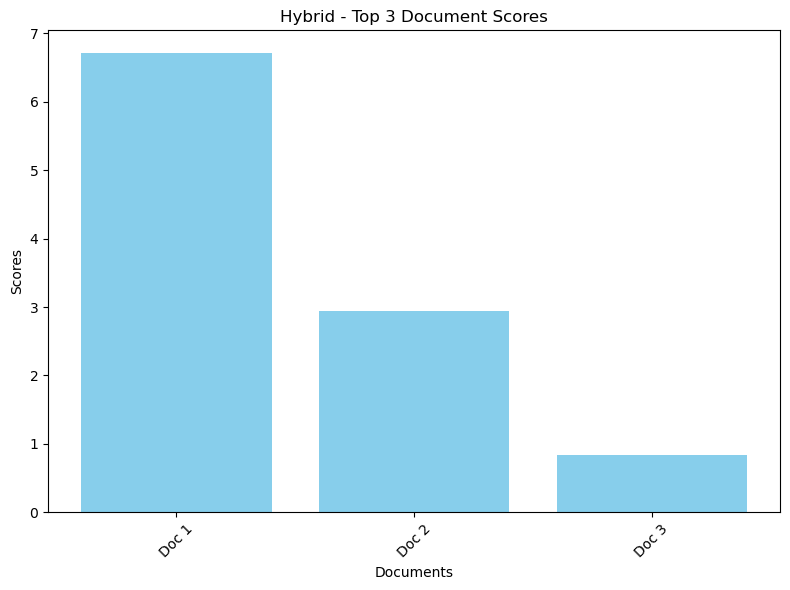

[ChatCompletionChoice(index=0, message=AssistantMessage(content='John Adams was married to Abigail Smith.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]
Hybrid Strategy Answer:
John Adams was married to Abigail Smith.



In [8]:
reranker = Reranker(type="hybrid")
ranked_docs, ranked_indices, scores = reranker.rerank(query, corpus)

display_results(ranked_docs, scores, "Hybrid", top_k=3)

top_doc = ranked_docs[:3]
answer = qa_generator.generate_answer(query, top_doc)
print(f"Hybrid Strategy Answer:\n{answer}\n")

### Analysis

The Hybrid Strategy merges the strengths of both the cross-encoder and TF-IDF approaches by combining their scores to rank documents. This method aims to balance the semantic understanding of the cross-encoder with the efficiency of TF-IDF. In the results, the top-ranked document scored 6.7050 and was the same highly relevant document identified by the cross-encoder alone. The second and third documents also mirrored those from the cross-encoder results but with adjusted scores due to the combined ranking.

The QA_Generator again produced the accurate answer, "John Adams was married to Abigail Smith." This consistency in answer quality indicates that the Hybrid Strategy effectively identifies relevant documents while potentially reducing computational costs compared to the cross-encoder alone. By incorporating TF-IDF scores, the hybrid model can prioritize documents that are both semantically relevant and contain key terms from the query.

We infer that the computational intensity of the Hybrid Strategy is moderate. While it still uses the resource-intensive cross-encoder, it can limit the number of documents processed by prioritizing those with high TF-IDF scores. The combination of scores allows for an initial filtering that reduces the total number of expensive computations. This understanding is based on the theoretical principle that combining a fast, efficient method (TF-IDF) with a slower, more accurate method (cross-encoder) can optimize overall performance.

In terms of system design, the Hybrid Strategy requires careful implementation to ensure that the integration of the two models is seamless. Adjusting the weights assigned to each model's scores is crucial for optimal performance and may require empirical tuning based on the specific corpus and query types. This strategy demands moderate computational resources, making it more scalable than the Cross-Encoder-Only approach but more resource-intensive than TF-IDF alone.

System design decisions must consider the added complexity of maintaining and updating two models within the system. Monitoring and logging become essential to diagnose performance issues or adjust weighting parameters. The Hybrid Strategy is suitable for applications where both accuracy and efficiency are important, as it offers a compromise that can meet user expectations without overwhelming system resources.

### Sequential Re-rank Strategy


Sequential Re-rank Results (Top 3):
Rank 1: Score 9.1589
Document: In 1764, Adams married Abigail Smith (1744–1818), the daughter of a Congregational minister,Rev. William Smith, at Weymouth, Massachusetts. Their children were Abigail (1765-1813); future president Jo...

Rank 2: Score 3.8088
Document: His daughter Abigail ("Nabby") was married to Congressman William Stephens Smith and died of cancer in 1816. His son Charles died as an alcoholic in 1800. His son Thomas and his family lived with Adam...

Rank 3: Score -3.7158
Document: John Adams, portrait by John Trumbull.
While Washington was the unanimous choice for president, Adams came in second in the electoral college and became Vice President in the presidential election of ...



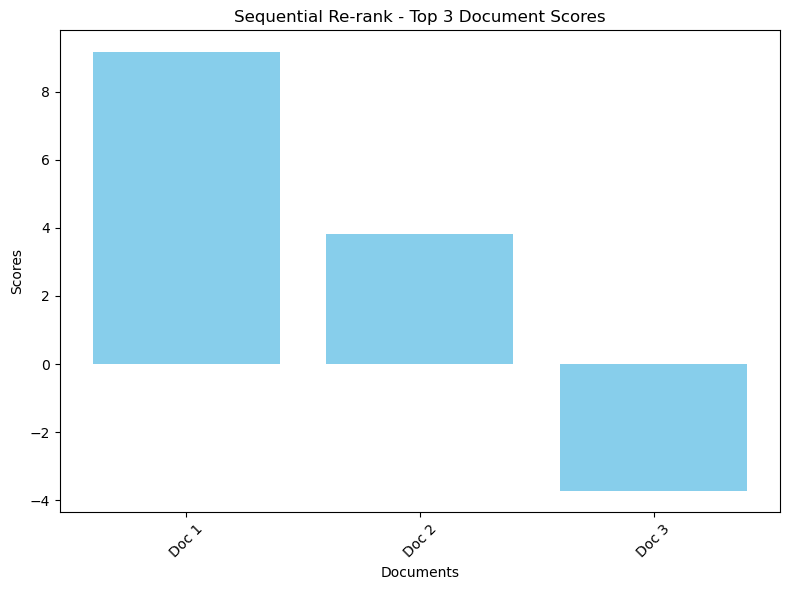

[ChatCompletionChoice(index=0, message=AssistantMessage(content='John Adams was married to Abigail Smith.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]
Sequential Re-rank Answer:
John Adams was married to Abigail Smith.



In [9]:
reranker = Reranker(type="sequential")
ranked_docs, ranked_indices, scores = reranker.sequential_rerank(query, corpus, top_k=5)

display_results(ranked_docs, scores, "Sequential Re-rank", top_k=3)

top_doc = ranked_docs[:3]
answer = qa_generator.generate_answer(query, top_doc)
print(f"Sequential Re-rank Answer:\n{answer}\n")

### Analysis

The Sequential Re-rank Strategy begins by employing TF-IDF to quickly filter the corpus, selecting the top-ranked documents based on lexical similarity to the query. These top documents are then passed to the cross-encoder for refined re-ranking based on semantic similarity. This approach aims to reduce computational load by limiting the number of documents that require the resource-intensive processing of the cross-encoder.

In the results, the top document had a high score of 9.1589 and directly addressed the query by detailing John Adams's marriage to Abigail Smith. The second document, with a score of 3.8088, discussed his daughter Abigail ("Nabby") and her marriage, which is related but not directly answering the query about John Adams's spouse. The third document, however, had a negative score of -3.7158 and was about John Adams's political career, mentioning nothing about his marriage. This document made it through the initial TF-IDF filtering into the cross-encoder stage, despite its lack of relevance to the query.

This observation highlights a significant downside of the Sequential Re-rank Strategy: the reliance on TF-IDF for initial filtering can result in both including irrelevant documents and excluding relevant ones. TF-IDF scores are based on lexical similarity, focusing on the frequency of shared terms between the query and the documents. In this case, the third-ranked document likely contained common terms like "John Adams" and "president," which boosted its TF-IDF score despite its irrelevance to the query about his marriage.

Conversely, semantically relevant documents that do not share exact terms with the query may be assigned low TF-IDF scores and thus be excluded from the cross-encoder re-ranking. For example, a document that refers to John Adams's wife using phrases like "his lifelong partner" or "the mother of his children" without explicitly mentioning "married" or "Abigail Smith" might be overlooked. This means that the Sequential Re-rank Strategy can miss important documents that are crucial for generating accurate answers, simply because they do not contain the specific keywords used in the query.

Despite the inclusion of an irrelevant document in the top results, the QA_Generator still managed to produce the correct answer, "John Adams was married to Abigail Smith," by utilizing the most relevant document. However, relying on chance that the top TF-IDF documents include the necessary information is not a robust strategy, especially in larger corpora where the proportion of irrelevant documents is higher.

This limitation affects the overall effectiveness of the system, particularly in scenarios where accurate and comprehensive information retrieval is critical. The reliance on lexical similarity for initial filtering introduces a trade-off between efficiency and the completeness of relevant information retrieval. The system may inadvertently filter out documents that are semantically relevant but lexically different, thereby undermining the quality of the final answer.

To address this issue, system design decisions must consider enhancing the initial filtering mechanism. One approach is to incorporate semantic search methods, such as using dense vector embeddings from models like Sentence-BERT, in conjunction with TF-IDF scores. This combination can help capture documents that are semantically related to the query, even if they lack keyword overlap. Another strategy is to increase the number of top documents selected by TF-IDF for cross-encoder re-ranking, thereby reducing the likelihood of excluding relevant information. However, this comes at the cost of increased computational load on the cross-encoder.

Adjusting the weighting between TF-IDF and cross-encoder scores, as seen in the Hybrid Strategy, may also alleviate some of these issues by allowing both lexical and semantic similarities to influence the final ranking. While the Sequential Re-rank Strategy offers notable computational efficiency by limiting cross-encoder processing to a subset of documents, its reliance on TF-IDF for initial filtering can result in both including irrelevant documents and excluding semantically relevant ones. This limitation can compromise the accuracy and reliability of the system, especially in larger datasets where the diversity of language and terminology is greater. System design decisions must carefully evaluate and potentially enhance the initial filtering process to balance efficiency with the need for precise and comprehensive answers. By integrating semantic search techniques and adjusting system parameters, it is possible to mitigate these downsides and improve the overall performance of the question-answering system.

### TF-IDF on Full Corpus Strategy


TF-IDF on Full Corpus Results (Top 3):
Rank 1: Score 0.1850
Document: Presidential Dollar of John Adams...

Rank 2: Score 0.1710
Document: In 1764, Adams married Abigail Smith (1744–1818), the daughter of a Congregational minister,Rev. William Smith, at Weymouth, Massachusetts. Their children were Abigail (1765-1813); future president Jo...

Rank 3: Score 0.1534
Document: His daughter Abigail ("Nabby") was married to Congressman William Stephens Smith and died of cancer in 1816. His son Charles died as an alcoholic in 1800. His son Thomas and his family lived with Adam...



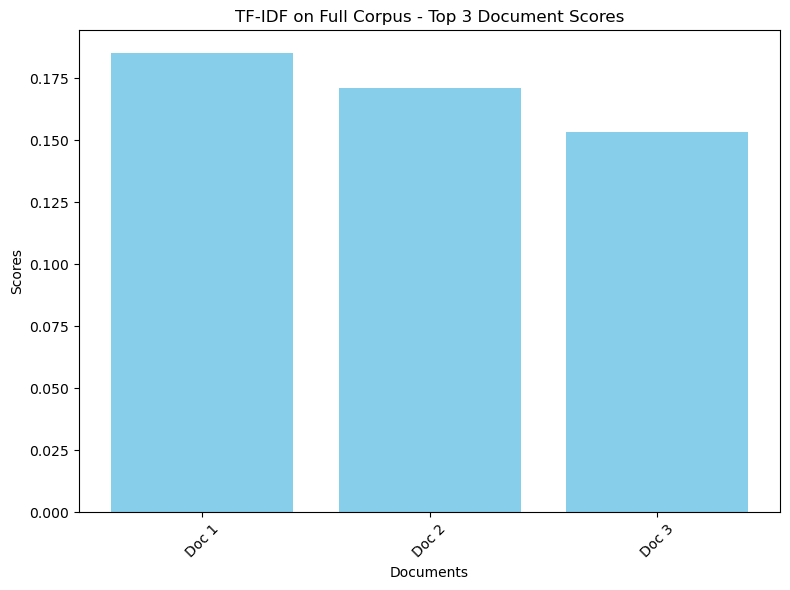

[ChatCompletionChoice(index=0, message=AssistantMessage(content='John Adams was married to Abigail Smith.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]
TF-IDF on Full Corpus Answer:
John Adams was married to Abigail Smith.



In [10]:
reranker = Reranker(type="tfidf_corpus")
ranked_docs, ranked_indices, scores = reranker.tfidf_corpus_rerank(query, corpus)

display_results(ranked_docs, scores, "TF-IDF on Full Corpus", top_k=3)

top_doc = ranked_docs[:3]
answer = qa_generator.generate_answer(query, top_doc)
print(f"TF-IDF on Full Corpus Answer:\n{answer}\n")

### Analysis

Applying TF-IDF on the full corpus without prior filtering tests the strategy's standalone effectiveness. In the results, the top-ranked document again was about the "Presidential Dollar of John Adams," which is not directly relevant to the query. The relevant document detailing his marriage was ranked second with a score of 0.1710. Despite the misranking, the QA_Generator produced the correct answer by utilizing multiple top documents as context.

This strategy demonstrates the limitations of TF-IDF when dealing with large corpora, as it may not sufficiently prioritize the most relevant documents. The efficiency of processing the full corpus is high due to the simplicity of TF-IDF calculations, but the lack of semantic understanding can hinder answer accuracy if not compensated by additional context.

This strategy demonstrates the limitations of TF-IDF when dealing with large corpora, as it may not sufficiently prioritize the most relevant documents. The efficiency of processing the full corpus is high due to the simplicity of TF-IDF calculations, but the lack of semantic understanding can hinder answer accuracy if not compensated by additional context.

We understand that TF-IDF remains computationally efficient even on large datasets because the calculations are linear and can be executed using optimized data structures and algorithms. The lack of semantic depth is a known limitation of TF-IDF, as it does not capture the meaning of words beyond their statistical occurrences.

From a system design perspective, relying solely on TF-IDF across a full corpus is suitable for systems where computational resources are minimal, and response times must be extremely fast. However, the potential impact on answer quality necessitates additional considerations. Designers might need to implement mechanisms to include more documents in the context or integrate supplementary methods to enhance relevance.

This strategy is less suitable for applications where precise answers are critical. It may be appropriate for preliminary data exploration or systems where users are expected to refine queries iteratively. Understanding the trade-offs between speed and accuracy is essential, and this knowledge comes from theoretical insights into information retrieval practices. To improve performance, system design decisions could consider incorporating lightweight semantic models or heuristic rules to boost relevant documents in the ranking. By integrating these enhancements, systems can achieve a better balance between efficiency and accuracy, ensuring that users receive more relevant answers without incurring significant additional computational costs. This approach enables the system to maintain high responsiveness while providing improved information retrieval, making it more effective across a wider range of applications.

### Conclusion

The analysis of these five re-ranking strategies reveals how theoretical knowledge of computational complexity and algorithmic behavior informs our understanding of their impact on system design. The Cross-Encoder-Only Strategy offers high precision but at the cost of significant computational resources, known from the resource demands of neural network models. The TF-IDF-Only and TF-IDF on Full Corpus strategies are efficient due to their simple mathematical operations but risk misranking relevant documents due to their inability to capture semantic meaning.

The Hybrid and Sequential Re-rank strategies provide a middle ground, balancing resource use with acceptable accuracy levels. However, the Hybrid strategy may be better than the Sequential Re-rank strategy in selecting semantically relevant documents. By combining TF-IDF and cross-encoder scores for each document, the Hybrid strategy allows both lexical and semantic similarities to influence the final ranking. This approach mitigates the risk of excluding important documents that may not be highly ranked by TF-IDF alone but are semantically relevant to the query. In contrast, the Sequential Re-rank strategy relies on TF-IDF for initial filtering, which can result in both including irrelevant documents and excluding semantically relevant ones, as it only passes the top lexical matches to the cross-encoder.

Our understanding of the computational intensity and efficiency of these strategies is based on combining the known properties of their constituent methods. The Hybrid strategy, while slightly more computationally intensive than the Sequential Re-rank strategy, offers improved accuracy by ensuring that semantically relevant documents are more likely to be included in the final ranking.

System design decisions must align the choice of strategy with the application's requirements, considering factors such as resource availability, expected query volume, and the criticality of precise answers. Incorporating multiple top-ranked documents into the context for the QA_Generator enhances the likelihood of producing accurate answers, particularly when the ranking strategy may not consistently place the most relevant document first. By integrating theoretical insights into computational intensity, speed, and scalability with empirical observations of model performance, we can make informed decisions that balance efficiency and accuracy in question-answering systems.

Understanding the inherent characteristics of each strategy allows us to predict their impact on system design, even without direct measurement of computational metrics. Recognizing that the Hybrid strategy may better capture semantically relevant documents highlights the importance of selecting a re-ranking approach that aligns with the system's goals. Ultimately, choosing the appropriate strategy involves balancing the trade-offs between computational resources and the need for accurate, reliable information retrieval.